# Simple Computer Vision with OpenCV+python

Bicocca Physics Hackathon - 2 Sep 2024

Martino Borsato

## What is OpenCV?

<img style="float:right;margin-left:3em;width:7em;" src="opencv_logo.svg">


OpenCV (Open Source Computer Vision Library) is an open source computer vision and machine learning software library. OpenCV has several functionalities:
- Image/video I/O, processing, display 
- Object/feature detection 
- Geometry-based monocular or stereo computer vision 
- Computational photography 
- Machine learning & clustering

We will just scratch the surface of what OpenCV can do, but you can find plenty of tutorials online if you want to learn more.

## How are we going to use OpenCV?
OpenCV is a C++ library, but it has bindings for many languages, including python. We will use python to write our code, but the underlying OpenCV code will be in C++ (very fast). 

We will acquire images and videos from the Raspberry Pi camera and process them with OpenCV in the Raspberry Pi. We can use this to track moving objects such as the laser spot of the Cavendish experiment or the falling spheres in the glicerine experiment.

## How to install OpenCV?
Installing OpenCV in Python 3 is trivial. Just open a terminal and type:

```bash
pip3 install opencv-python
```

# Acquiring images and videos

## Image acquisition

In [156]:
import cv2

Initialise the video capture from default camera `0`

In [124]:
cap = cv2.VideoCapture(0)

Acquire a frame and release the capture stream

In [125]:
ret, frame = cap.read()
cap.release() # always remember to release the capture!

Show the image using `matplotlib`

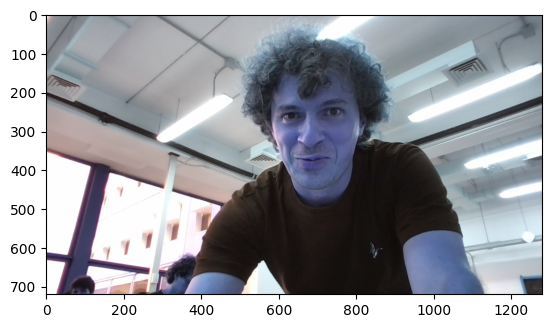

In [126]:
import matplotlib.pyplot as plt
plt.imshow(frame);

Let's fix the colour. OpenCV captures the image in BGR (Blue, Green, Red) format, but `plt.imshow` wants it in RGB format. We can use a function of `cv2` to fix that.

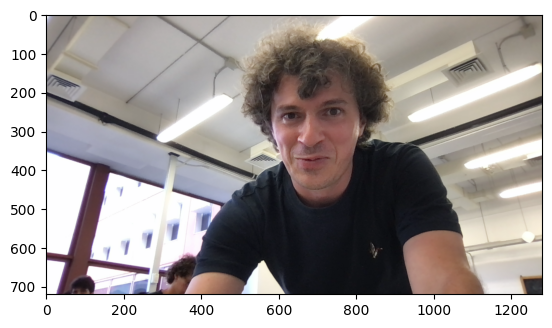

In [127]:
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame_rgb);

Let's define a simple function for that

In [128]:
def plotOpenCVImage(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    fig = plt.imshow(image_rgb)
    return fig

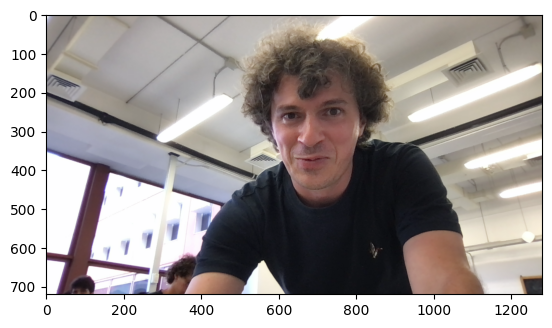

In [129]:
plotOpenCVImage(frame);

The NumPy array representing the image has three dimensions: the first two are the height and width of the image, the third is the colour channel. 

In our case, we have three BGR channels.

In [130]:
print(f'The shape of the image is {frame.shape}')

The shape of the image is (720, 1280, 3)


For an image in grayscale, we have only one channel.

The shape of the grayscale image is (720, 1280)


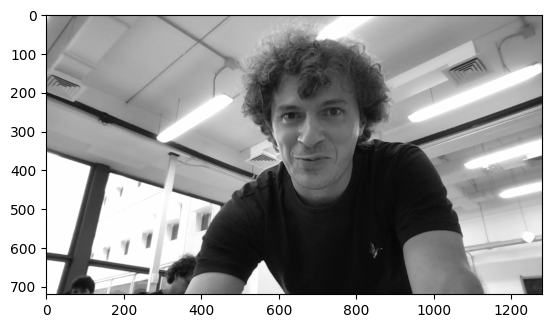

In [131]:
frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # convert to greyscale
print(f'The shape of the grayscale image is {frame_gray.shape}')
plt.imshow(frame_gray, cmap='gray');

Note: the pixels are indexed as `image[y, x, channel]`, not as `image[x, y, channel]`. Also, the `y` index starts from the top, not from the bottom.

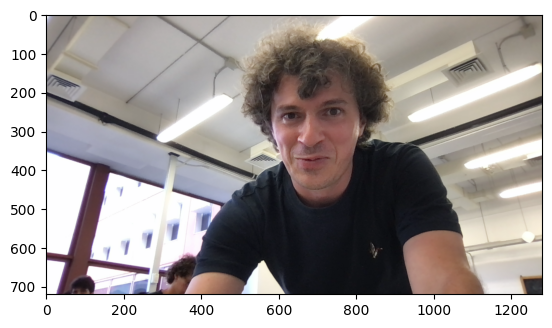

In [132]:
plotOpenCVImage(frame);

What corner of the image do I select with the following?

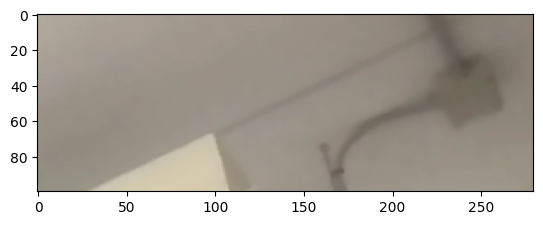

In [133]:
plotOpenCVImage(frame[0:100, 1000:1280]);

## Image saving and loading

Save the image to disk using `cv2.imwrite`

In [134]:
# save the image to file
cv2.imwrite('test_image.png', frame)

True

Load the image from disk using `cv2.imread`

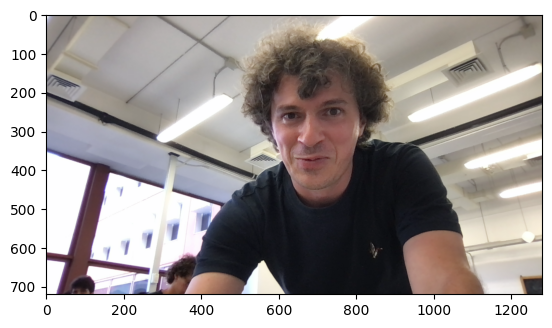

In [135]:
# load the image from file
loaded_image = cv2.imread('test_image.png')
plotOpenCVImage(loaded_image);

## Video acquisition

Acquiring a video is as simple as reading many frames from `cv2.VideoCapture`. However, writing the output to a file requires us to correctly initialise a `cv2.VideoWriter` object.

In [136]:
import time

def RecordVideo(outfilename, record_duration_s = 3):
    cap = cv2.VideoCapture(0)
    
    # set resolution and framerate
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = 30 # getting it from cap.get(cv2.CAP_PROP_FPS) does not work for my webcam
    
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(outfilename, fourcc, fps, (frame_width, frame_height))

    print(f'Recording video for {record_duration_s} seconds with resolution {frame_width}x{frame_height}')    
    time_begin = time.time()
    for i in range(0, fps * record_duration_s):
        ret, frame = cap.read()
        out.write(frame)
    time_end = time.time()
    print(f'Elapsed time is {time_end-time_begin}')
    
    cap.release()
    out.release()
    print(f'Video written to {outfilename}')

In [137]:
RecordVideo('test_video.avi', record_duration_s=3)

Recording video for 3 seconds with resolution 1280x720
Elapsed time is 3.0762829780578613
Video written to test_video.avi


You can check the output video file created by opening it with `ffplay` or `vlc`.

## Read in a video file

Reading in a video file frame by frame is very similar to reading from a camera. We just need to initialise the `cv2.VideoCapture` object with the path to the video file instead of the camera number.

In [138]:
# Open the video capture from the AVI video file
cap = cv2.VideoCapture('test_video.avi')

# Get the number of frames in the video
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f'The video contains {n_frames} frames')

The video contains 90 frames


In [139]:
# Read frames one by one
for i in range(9):
    ret, frame = cap.read()
    
    # Do something with the frame before moving on to the next one...

# don't forget to release the video capture
cap.release()

## Read in a video file: an example

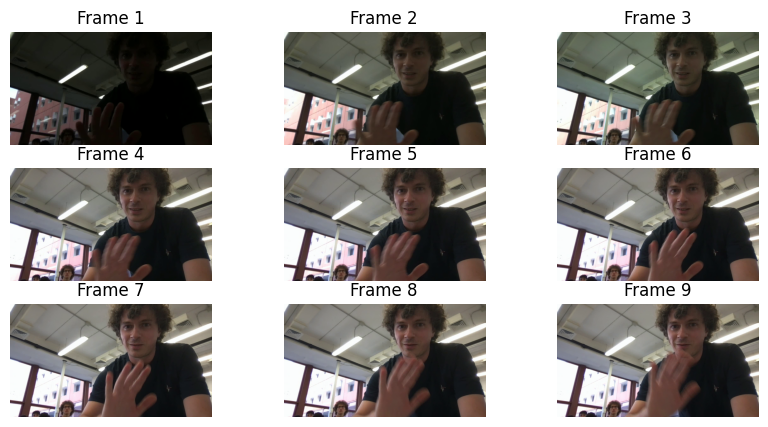

In [140]:
# Open the video capture from the AVI video file
cap = cv2.VideoCapture('test_video.avi')

fig, axes = plt.subplots(3, 3, figsize=(10, 5))

# Read frames one by one
for i in range(9):
    ret, frame = cap.read()
        
    # print the frame in a 3x3 grid
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    ax = axes[i // 3, i % 3]
    ax.imshow(frame_rgb)
    ax.set_title(f"Frame {i+1}")
    ax.axis('off') 

cap.release()

If you want to grab a specific frame you don't need to loop. You can use the `cap.set` method to set the frame number. Note that the frame number is 0-based, so the first frame is frame 0.

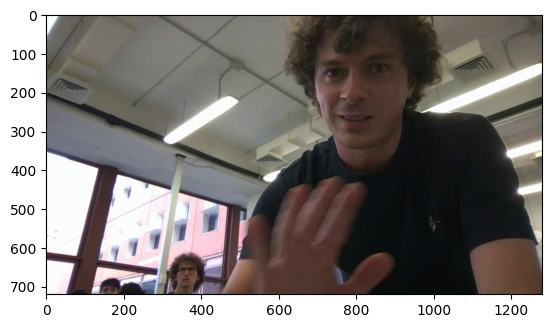

In [141]:
# get the 10th frame in the video
cap = cv2.VideoCapture('test_video.avi')
cap.set(cv2.CAP_PROP_POS_FRAMES, 3)
ret, frame = cap.read()
cap.release()

plotOpenCVImage(frame);

# Object detection

Let's use a simple picture of a plane with coloured dots to learn how to detect objects in an image.

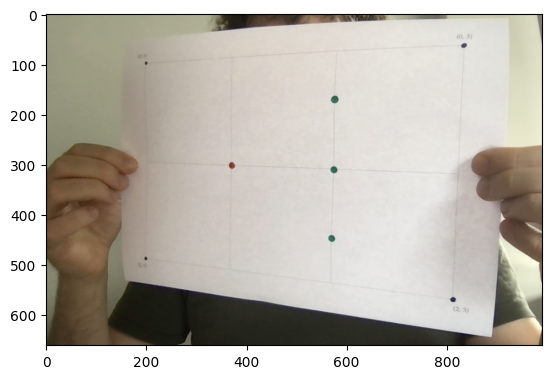

In [142]:
image = cv2.imread('test_dots.png')
plotOpenCVImage(image);

## Masking

Apply a mask to remove the part of the picture that may confuse the points identification algorithm. The mask is simply a NumPy array with values equal to 0 or 1 depending on whether the pixel should be kept or not.

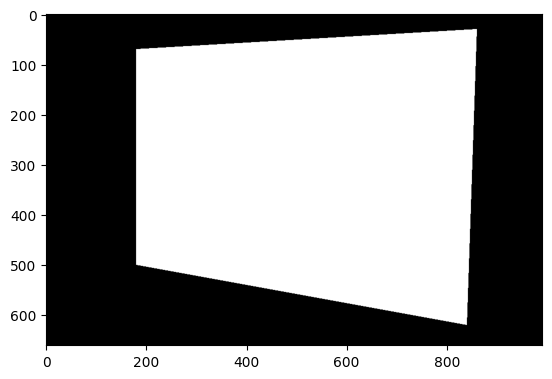

In [143]:
# first create mask as a null matrix with the same shape as the image
import numpy as np
mask = np.zeros(image.shape[:2], dtype=np.uint8)

# then mask the region outside of these four corners
mask_corners = np.array([[180, 70], [860, 30], [840, 620], [180, 500]])
cv2.drawContours(mask, [mask_corners], -1, 255, -1)
plt.imshow(mask, cmap='gray');

We can now apply the mask to our image by using `cv2.bitwise_and`, which makes a logical AND of all the pixels, and turns the ones that are black in the mask off in the masked image.

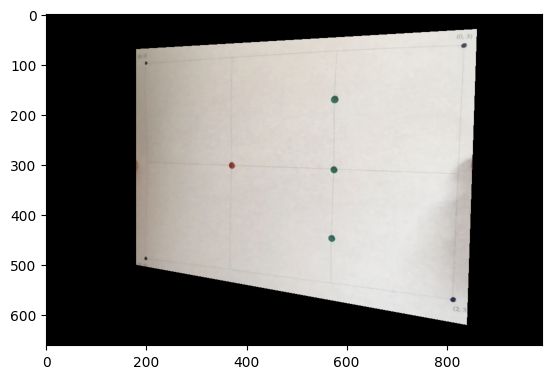

In [144]:
masked_image = cv2.bitwise_and(image, image, mask=mask)
plotOpenCVImage(masked_image);

## Coloured dots identification

<img style="float:right;margin-left:3em;width:8em;" src="hsv.png">
In order to identify coloured dots it helps to move to the HSV (Hue, Saturation, Value) colour space. The Hue is the colour, the Saturation is the intensity of the colour, and the Value is the brightness. The HSV colour space is more intuitive than the RGB/BGR colour space, and it is easier to identify colours in it.

In [145]:
hsv_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2HSV)

The we use `cv2.inRange` to select the pixels that have a Hue value between the minimum and maximum values we want to select. Green has a hue value around $80$. The range we allow is $\pm 10$ but can be tweaked to be more or less inclusive.

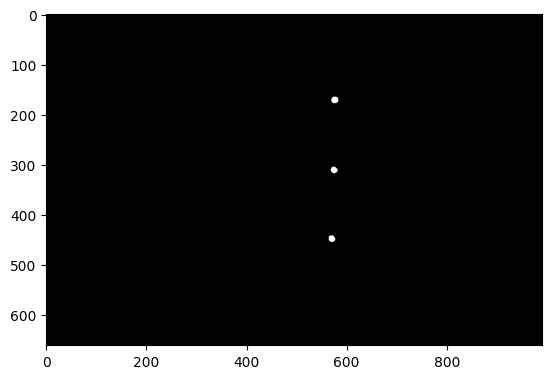

In [146]:
lower_green = np.array([70, 40, 40])    # Lower bound for green hue (adjust as needed)
upper_green = np.array([90, 255, 255])  # Upper bound for green hue (adjust as needed)
green_regions = cv2.inRange(hsv_image, lower_green, upper_green)
plt.imshow(green_regions, cmap='gray');

We then use `cv2.findContours` to find the contours of the green objects in the image. We can then loop over the contours and find the centroid (mean pixel position) of each object by using `cv2.moments`.

Centroid of green dot: (x, y) = (570.6, 448.1)
Centroid of green dot: (x, y) = (575.2, 310.9)
Centroid of green dot: (x, y) = (576.6, 171.1)


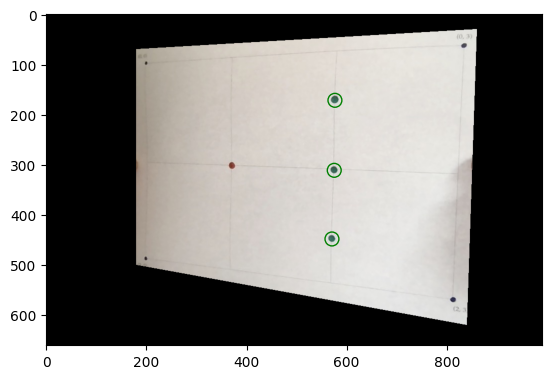

In [147]:
plotOpenCVImage(masked_image);
contours, _ = cv2.findContours(green_regions, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

green_dots_positions = []
for contour in contours:
    if cv2.contourArea(contour) > 50:  # Minimum contour area threshold
        M = cv2.moments(contour)
        center_x = M["m10"] / M["m00"]
        center_y = M["m01"] / M["m00"]
        print(f"Centroid of green dot: (x, y) = ({center_x:.1f}, {center_y:.1f})")
        plt.scatter(center_x, center_y, color='green', marker='o', facecolor='none', s=100);
        green_dots_positions.append([center_x, center_y])

# Perspective transformation and calibration

We want to measure the position of the identified dots in a given plane a set of coordinates. To calibrate and correct for perspective we need 4 points in the image and their corresponding coordinates in the plane.

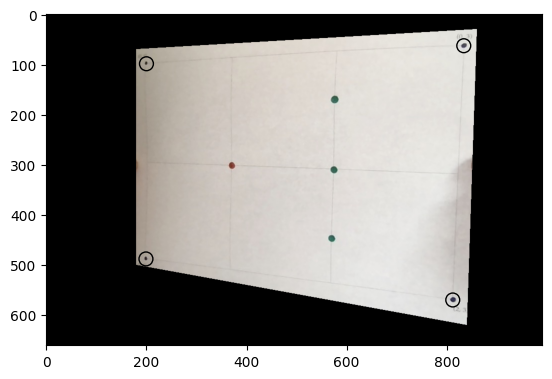

In [148]:
calibration_pixels = np.array([[199, 488], [200, 98], [812, 570], [834, 62]], dtype=np.float32)
for x, y in calibration_pixels:
    plt.scatter(x, y, color='black', marker='o', facecolor='none', s=100)

# the corresponding coordinates in the plane are:
calibration_coords = np.array([[0, 0], [0, 2], [3, 0], [3, 2]], dtype=np.float32)

plotOpenCVImage(masked_image);

We can then use OpenCV to calculate map the pixel position of the points in the image to their position in the plane. 

We use a perspective transformation because the camera sensor is not parallel to the plane.

In [149]:
transform_matrix = cv2.getPerspectiveTransform(calibration_pixels, calibration_coords)

def get_coordinates(x_pixel, y_pixel, transform_matrix=transform_matrix):
    point_pixels = np.array([[x_pixel], [y_pixel], [1]], dtype=np.float32)
    point_coords = transform_matrix.dot(point_pixels)
    point_coords = point_coords / point_coords[2]
    return point_coords[0][0], point_coords[1][0]

Now let's try our calibration on the green dots we identified before.

Can we get their coordinates in the plane correctly?

Green dot at (x, y) = (2.0, 0.4)
Green dot at (x, y) = (2.0, 1.0)
Green dot at (x, y) = (2.0, 1.6)


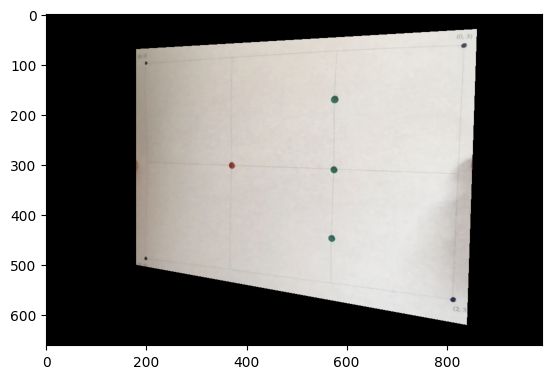

In [150]:
for x, y in green_dots_positions:
    x_coord, y_coord = get_coordinates(x, y)
    print(f"Green dot at (x, y) = ({x_coord:.1f}, {y_coord:.1f})")
plotOpenCVImage(masked_image);

In [ ]:
gray = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
plotOpenCVImage(gray)

In [ ]:
blurred = cv2.GaussianBlur(masked_image, ksize=(11, 11), sigmaX=0)
plotOpenCVImage(blurred)

# Live video processing

We want to display the frames in jupyter notebooks as we capture them

In [151]:
from IPython.display import display, clear_output
import PIL.Image

# Function to display an image inside Jupyter Notebook
def show_image(image, display_id='stream'):
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Convert to PIL Image for IPython display
    img_pil = PIL.Image.fromarray(img_rgb)
    # Clear previous output and display new image
    clear_output(wait=True)
    display(img_pil)

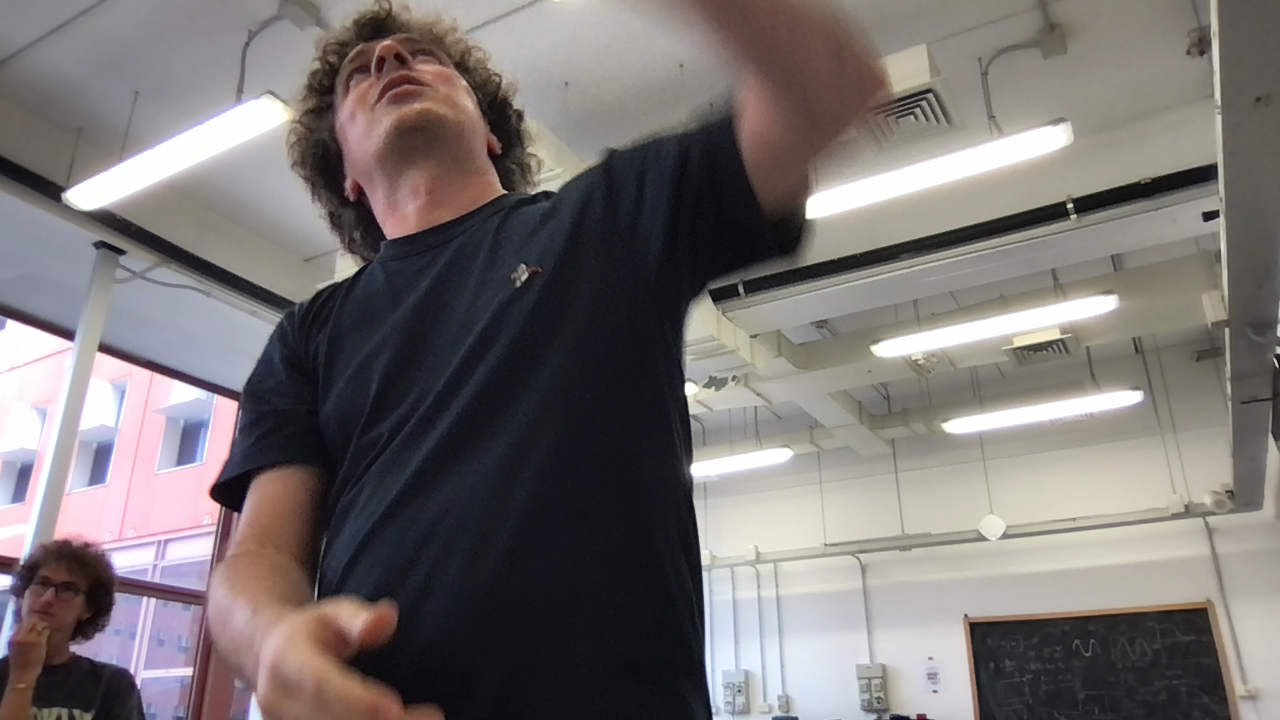

In [152]:
cap = cv2.VideoCapture(0)
for i in range(20):
        ret, frame = cap.read()
        show_image(frame)
cap.release()

We can also process the image and see the effect

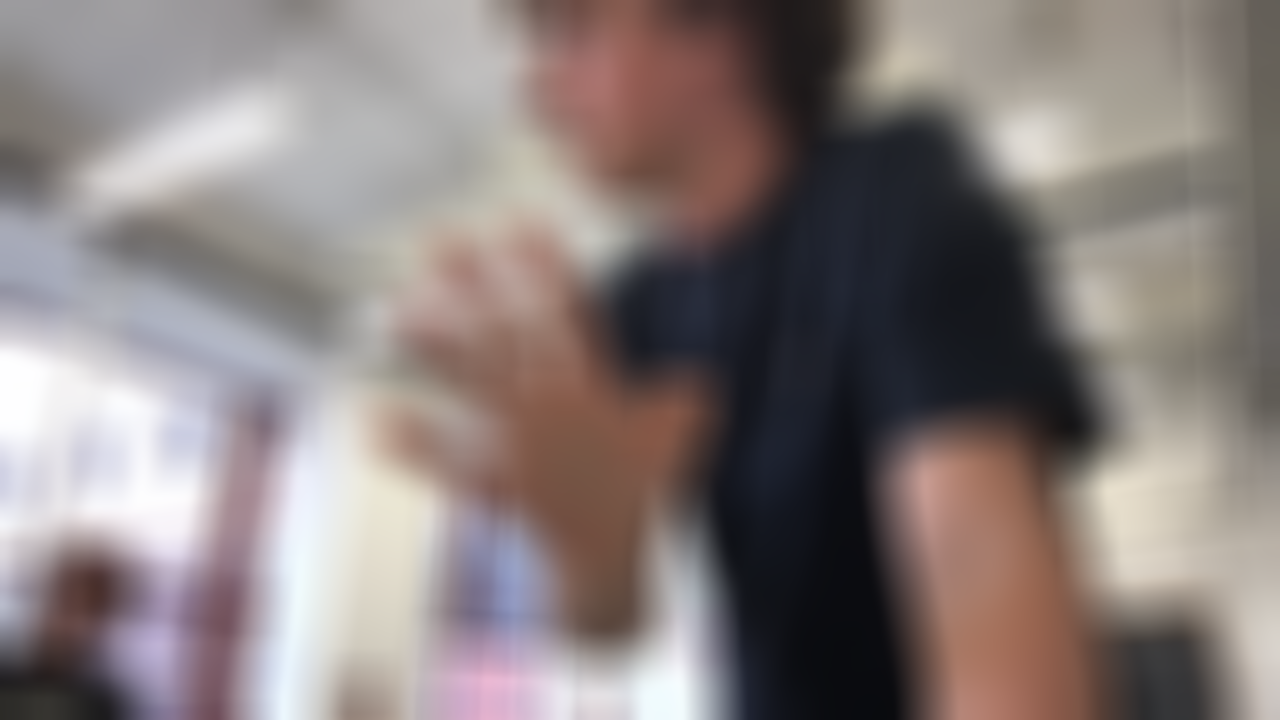

In [153]:
cap = cv2.VideoCapture(0)
for i in range(20):
        ret, frame = cap.read()
        processed_frame = cv2.GaussianBlur(frame, ksize=(65, 65), sigmaX=100)
        show_image(processed_frame)
cap.release()

We can also take the difference between to subsequent frames. This can be useful to identify moving objects.

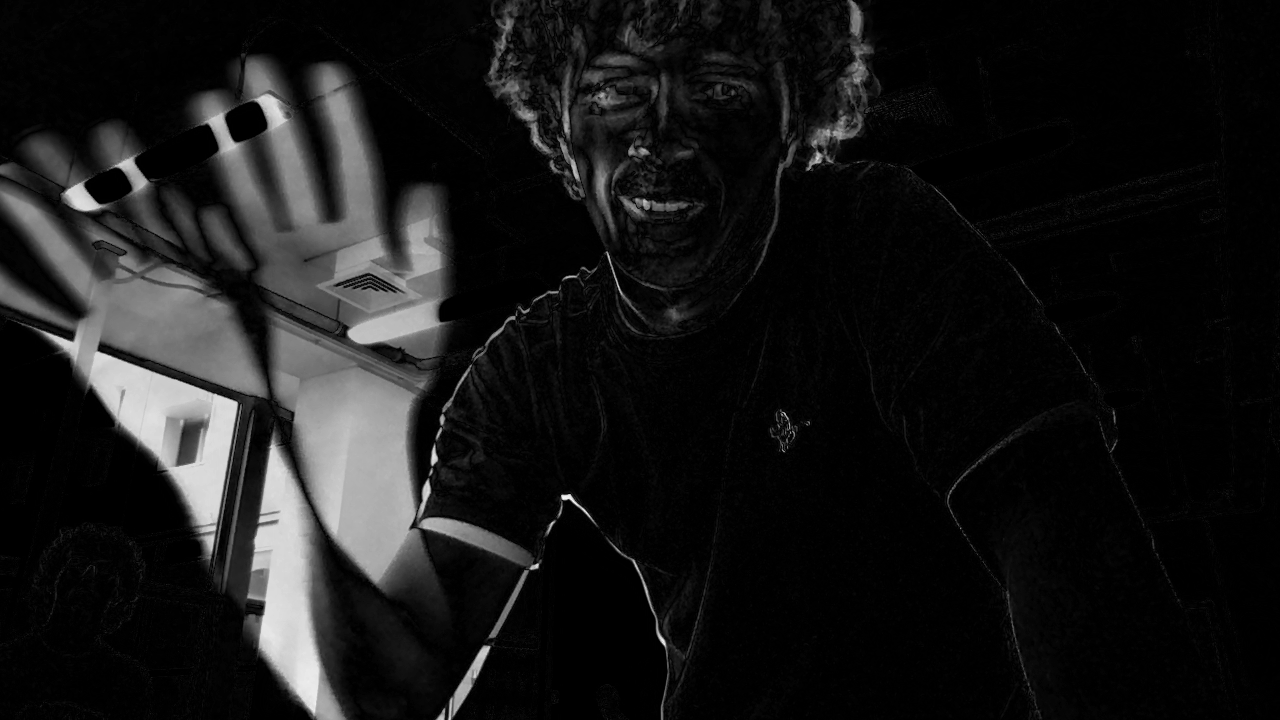

In [155]:
cap = cv2.VideoCapture(0)

# Initialize the previous frame
_, frame = cap.read()
previous_frame = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)

for i in range(20):
    _, current_frame = cap.read()
    current_frame_gray = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
    
    # Compute the absolute difference between the current frame and the previous frame
    frame_diff = cv2.absdiff(current_frame_gray, previous_frame)
    # Normalize the difference for better visualization
    frame_diff_normalized = cv2.normalize(frame_diff, None, 0, 255, cv2.NORM_MINMAX)
    show_image(frame_diff_normalized)
    
    previous_frame = current_frame_gray

cap.release()

# Summary

We have seen how to use OpenCV to:
- Acquire images and videos
- Save and load images and videos
- Mask unintesting parts of the image
- Identify coloured dots in the image
- Transform pixel positions in coordinates in a plane
- Show processed images live in your jupyter notebook

# How can you use this?

* Use the Raspberry Pi camera or a camera connected to your computer
* Track objects and get their position in a given reference frame
* Use these coordinates to analyse the motion of the objects
* You can analyse the data in python and get results in real time
* You can use OpenCV to load and preprocess images before using ML to analyse them